In [ ]:
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
#learning rate
init_lr = 1e-4  
epochs = 20
bs = 32

In [ ]:
#Loading and pre-processing our training data
imagePaths_mask = []
imagePaths_nomask = []

for filename in os.listdir("/content/drive/MyDrive/mesked_dataset/Dataset/train/train/with_mask"):
  imagePaths_mask.append(filename)
for filename in os.listdir("/content/drive/MyDrive/mesked_dataset/Dataset/train/train/without_mask"):
  imagePaths_nomask.append(filename)

In [ ]:
data = []
labels = []

for img in imagePaths_mask:

  label = 'with_mask'
  #Loads an image into PIL format.
  image = load_img("/content/drive/MyDrive/mesked_dataset/Dataset/train/train/with_mask/"+img, target_size=(224,224))
  #Converts a PIL Image instance to a Numpy array.
  image = img_to_array(image)
  #pre_process input according to model's parameter
  image = preprocess_input(image)

  data.append(image)
  labels.append(label)

In [ ]:
for img in imagePaths_nomask:

  label = 'without_mask'

  image = load_img("/content/drive/MyDrive/mesked_dataset/Dataset/train/train/without_mask/"+img, target_size=(224,224))
  image = img_to_array(image)
  image = preprocess_input(image)

  data.append(image)
  labels.append(label)
print("ok")

ok


In [ ]:
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [ ]:
print(labels)

['with_mask' 'with_mask' 'with_mask' ... 'without_mask' 'without_mask'
 'without_mask']


In [ ]:
#encoding our lables to 0's and 1;s
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
print("Text categories in number form: \n",labels)
#Converting a class vector to binary class matrix
labels = to_categorical(labels)
print("One Hot Encoding: \n",labels)

labels.shape

Text categories in number form: 
 [[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]
One Hot Encoding: 
 [[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


(1315, 2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


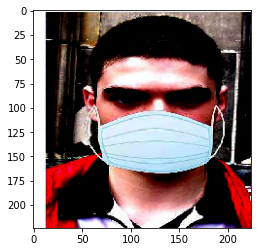

In [ ]:
plt.imshow(data[0])

In [ ]:
#Splitting Training and Testing Data
(train_x,test_x,train_y,test_y) = train_test_split(data, labels, test_size = 0.20, stratify = labels, random_state = 42)


In [ ]:
# Initialising train_generator for data augmentation
train_generator = ImageDataGenerator(
                    rotation_range = 20,
                    zoom_range = 0.15,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.15,
                    horizontal_flip = True,
                    fill_mode="nearest"
                  )

In [ ]:
# Using MobileNetV2 as the base model and Fine Tuning it
baseModel = MobileNetV2(input_tensor = tf.keras.layers.Input(shape = (224,224,3)),include_top = False, weights = 'imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
#1.   Load MobileNet with pre-trained ImageNet weights, leaving off head of network.
#2.   Construct a new FC head, and append it to the base in place of the old head.
#3.   Freeze the base layers of the network. The weights of these base layers will not be updated during the process of backpropagation, whereas the head layer weights will be tuned.
baseModel

baseModel.output          

headModel = baseModel.output              
headModel = tf.keras.layers.AveragePooling2D(pool_size = (7,7))(headModel)
headModel = tf.keras.layers.Flatten()(headModel)
headModel = tf.keras.layers.Dense(128, activation = 'relu')(headModel)
headModel = tf.keras.layers.Dropout(0.5)(headModel)
headModel = tf.keras.layers.Dense(2, activation = 'softmax')(headModel)


In [ ]:
model = tf.keras.models.Model(inputs = baseModel.input, outputs = headModel)

In [ ]:
baseModel.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [ ]:
baseModel.layers

In [ ]:
for layers in baseModel.layers:
  baseModel.trainable = False


In [ ]:
#Compiling the model
opt = Adam(lr = init_lr, decay = init_lr/epochs)
model.compile(optimizer=opt, loss = 'binary_crossentropy',metrics = ['accuracy'])

In [ ]:
#Fitting the model
history = model.fit(train_generator.flow(train_x,train_y,batch_size=bs),
                    steps_per_epoch = len(train_x)//bs,
                    validation_data = (test_x,test_y),
                    validation_steps = len(test_x)//bs,
                    epochs = epochs,
                    verbose = 1
                    )

Epoch 1/20
32/32 [==============================] - 60s 2s/step - loss: 0.7364 - accuracy: 0.6136 - val_loss: 0.2812 - val_accuracy: 0.9658
Epoch 2/20
32/32 [==============================] - 54s 2s/step - loss: 0.2916 - accuracy: 0.9231 - val_loss: 0.1457 - val_accuracy: 0.9696
Epoch 3/20
32/32 [==============================] - 55s 2s/step - loss: 0.1633 - accuracy: 0.9727 - val_loss: 0.1013 - val_accuracy: 0.9734
Epoch 4/20
32/32 [==============================] - 55s 2s/step - loss: 0.1206 - accuracy: 0.9743 - val_loss: 0.0784 - val_accuracy: 0.9734
Epoch 5/20
32/32 [==============================] - 55s 2s/step - loss: 0.0852 - accuracy: 0.9913 - val_loss: 0.0664 - val_accuracy: 0.9734
Epoch 6/20
32/32 [==============================] - 55s 2s/step - loss: 0.0703 - accuracy: 0.9835 - val_loss: 0.0563 - val_accuracy: 0.9772
Epoch 7/20
32/32 [==============================] - 55s 2s/step - loss: 0.0701 - accuracy: 0.9830 - val_loss: 0.0526 - val_accuracy: 0.9772
Epoch 8/20
32/32 [==

In [ ]:
#"""## Saving our model"""
model.save("/content/drive/MyDrive/mesked_dataset/models/")  # as .pb

model.save("/content/drive/MyDrive/mesked_dataset/models/My_Model.h5")
print("ok") 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/mesked_dataset/models/assets
ok


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
epochs = range(len(acc))

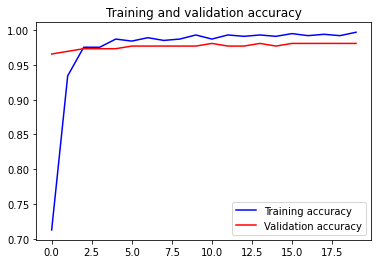

In [ ]:
# Plotting our performance"""
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()


In [ ]:
plt.figure()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

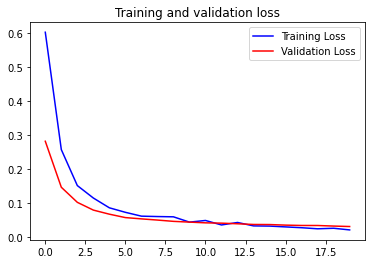

In [ ]:
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()